# Chemical Equilibrium VI

These exercises will reinforce solution of general problems in chemical equilibrium for gas phase reactions at any temperature and pressure.  We will cover how to handle non-ideality at high pressure by working with fugacity coefficients.  We continue to build proficiency with Python and computer aided solutions by introducing Gaussian Quadrature as a tool for solving definite integrals numerically. This exercise should strengthen fundamentals of thermodynamics in reacting systems and improve confidence with Python, especially for solving problems that would be tedious or perhaps impossible to do by hand.

In [5]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

## The definitive analysis of ammonia synthesis...

In preceding Notebooks, we have considered the gas-phase reaction of molecular nitrogen with molecular hydrogen to produce ammonia:

$$N_2 (g) + 3H_2 (g) \leftrightarrow 2N\!H_3 (g)$$

We have always considered the reaction between 1 mole of $N_2$ and 3 moles of $H_2$. With that starting state in mind, we have thus far solved the problem in each of the following cases, finding the equilibrium conversions of $N_2$ indicated:

1. 298K and 1 bar ([Notebook 07](https://jqbond.github.io/CEN587/Notebooks/587-N07.html)): $X_{N_2} = 0.97$
2. 873K and 1 bar without a catalyst ([Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html#example-problem-01)): $X_{N_2} = 8.0 \times 10^{-4}$ 
3. 873K and 1000 bar without a catalyst ([Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html#what-can-we-do-to-improve-the-equilibrium-conversion?)): $X_{N_2} = 0.38$
4. 673K and 200 bar with a catalyst ([Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html#this-really-doesn't-seem-industrially-feasible)): $X_{N_2} = 0.51$

In each of these cases, we assumed ideal gas behavior no matter how high the pressure was. Clearly, this is incorrect. Today, we will build thermodynamic non-ideality into our solution by calculating fugacity coefficients. In doing so, we will reinforce concepts in programming from [Notebook 09](https://jqbond.github.io/CEN587/Notebooks/587-N09). Specifically, we will set this problem up in a general way that allows us to easily solve for equilibrium converstion at any $(T,P)$ condition. We will do this by ***passing $T$ and $P$ as extra parameters to our objective function***.

### Solution

In all cases, we are solving the following equation:

$$\exp\left(\frac{-\Delta G^\circ}{RT}\right) = K = \prod_{j = 1}^{N_S}a_j^{\nu_j}$$

#### Calculating Equilibrium Constants

**Reference State for ammonia synthesis reaction:** Pure gases at $T^\circ$ = Reaction Temperature, and $P^\circ$ = 1 bar.  We need to define our $\Delta G^\circ$ under these conditions. We were able to look up the following data for $N_2$, $H_2$, and $N\!H_3$ as pure gases at 298K and 1 bar.

|Species      | ${H_j}^\circ (\mathrm{kJ \ mol^{-1}})$| ${S_j}^\circ (\mathrm{J \ mol^{-1} \ K^{-1}})$ | ${C_{p_j}}^\circ (\mathrm{J \ mol^{-1} \ K^{-1}})$|
|-------------|:-------------------------------------:|:----------------------------------------------:|:-------------------------------------------------:|
| $N_2$ (g)   | 0                                     |191.60                                          |29.12                                              | 
| $H_2$ (g)   | 0                                     |130.68                                          |28.84                                              | 
| $N\!H_3$ (g)| -45.9                                 |192.77                                          |35.64                                              |

This information is all we need to calculate the following:

* $\Delta H$ at any temperature, i.e. $\Delta H(T)$
* $\Delta S$ at any temperature, i.e. $\Delta S(T)$
* $\Delta G$ at any temperature, i.e. $\Delta G(T)$
* $K$ at any temperature, i.e. $K(T)$

We already did this in [Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html#example-problem-01), so this is nothing new. We'll just use the next cells to define global workspace variables (things that are constant throughout this entire analysis) and create a function for K(T). 

```{tip}
The equilibrium constant, $K$, is a function only of temperature for a given reaction. It does not depend on pressure or the starting composition of the mixture. We account for these in the definitions of thermodynamic activities. Ultimately, the effect of temperature on a chemical equilibrium problem is fully described by the value of $K$, whereas pressure and composition effects are described by the values of thermodynamic activities, $a_j$.
```

In [6]:
#############################################################
# Can define any fixed parameter values in global workspace #
# These values will be accessible anywhere in the worksheet #
# This includes inside of functions and loops               #
#############################################################

# Basis that gives 1:3 mole ratio of N2:H2
NN0 = 1 #mole
NH0 = 3 #moles
NA0 = 0 #moles
NT0 = NN0 + NH0 + NA0 #moles

# Reference pressure for ΔGᵒ and activity calculations
P0  = 1 #bar

# Thermodynamic data, tabulated at T = 298K, P = 1bar
T0 = 298   #K

#Enthalpies at 298K, 1 bar
HN0 = 0
HH0 = 0
HA0 = -45.9*1000 #J/mol

#Entropies at 298K, 1 bar
SN0 = 191.60 #J/mol/K
SH0 = 130.68 #J/mol/K
SA0 = 192.77 #J/mol/K

#Heat capacities
CPN = 29.12 #J/mol/K
CPH = 28.84 #J/mol/K
CPA = 35.64 #J/mol/K

#Gas constant
R = 8.314 #J/mol/K

In [7]:
def K(T):
    #Calculate thermodynamic state functions at T not equal to T0 = 298
    HN = HN0 + CPN*(T - T0) #J/mol
    HH = HH0 + CPH*(T - T0) #J/mol
    HA = HA0 + CPA*(T - T0) #J/mol

    SN = SN0 + CPN*np.log(T/T0) #J/mol/K
    SH = SH0 + CPH*np.log(T/T0) #J/mol/K
    SA = SA0 + CPA*np.log(T/T0) #J/mol/K

    DH = 2*HA - HN - 3*HH #J/mol
    DS = 2*SA - SN - 3*SH #J/mol/K
    DG = DH - T*DS        #J/mol

    K  = np.exp(-DG/R/T)     #Dimensionless
    return K

#### Thermodynamic activities capture composition and pressure effects

Now we have to unpack the composition dependencies buried within thermodynamic activities, i.e., we have solved for K(T), and we need to work on the right hand side of the equilbrium equation:

$$K = \prod_{j = 1}^{N_S}a_j^{\nu_j}$$

As illustrated in prior analyses of ammonia synthesis, if we expand the product operator, $\prod$, for ammonia synthesis, we find:

$$K = \frac{{a_{N\!H_3}}^{2}}{{a_{N_2}}{a_{H_2}}^3}$$

Regardless of the reaction temperature or pressure (or even phase of matter), we always define a thermodyanmic activity as:

$$a_j = \frac{\hat{f}_j}{f_j^\circ}$$

The numerator is the fugacity of species $j$ under reaction conditions $(T, P, \chi_j)$. The denominator is the fugacity of species $j$ in its reference state. Our reference state for gas-phase species is a pure species at 1 bar and the reaction temperature, $T$. Our convention for calculating fugacities of gases in a mixture uses the Lewis-Randall rule.  As usual, this gives:

$$a_j = \frac{y_j \phi_j P}{y_j^\circ \phi_j^\circ  P^\circ}$$

Looking at the numerator, we are operating this reactor at an unknown pressure, $P$, so we aren't yet sure about the fugacity coefficient in the numerator, $\phi_j$. Looking at the denominator, the reference state is a pure species, so $y_j^\circ = 1$. Further, that pure species is at 1 bar, so $\phi_j^\circ = 1$. This gives a very general result for activities of gases in a mixture. Here, we will retain the fugacity coefficient and not assume that it is equal to 1; this is essential for us to consider thermodynamically non-ideal gas behavior at high pressures:

$$a_j = \frac{y_j \phi_j P}{P^\circ}$$

For completeness sake, just to make clear what shows up in the one "equation" we are trying to solve, substituting the activity definition for each species into the equilibrium equation gives:

$$K = \frac{\left(\frac{y_{N\!H_3} \phi_{N\!H_3} P}{P^\circ}\right)^2}{\left(\frac{y_{N_2}\phi_{N_2}P}{P^\circ}\right) \left(\frac{y_{H_2}\phi_{H_2}P}{P^\circ}\right)^3}$$

We see multiple pressures and reference pressures that will cancel, giving:

$$K = \frac{{y_{N\!H_3}}^2}{y_{N_2}{y_{H_2}}^3} \frac{{\phi_{N\!H_3}}^2}{\phi_{N_2}{\phi_{H_2}}^3}\left(\frac{P^\circ}{P}\right)^2$$

This is a completely general equation that will apply at any Temperature or Pressure, so we can always use this result, regardless of the operating conditions.  As it stands, even after we specify temperature and pressure, we have many unknowns in the above equation. By specifying temperature and pressure we will define $K$ and $P$ for this system, but we still don't know:

1. The mole fraction of Nitrogen $(y_{N_2})$.
2. The mole fraction of Hydrogen $(y_{H_2})$.  
3. The mole fraction of Ammonia $(y_{N\!H_3})$ 
4. The fugacity coefficient of Nitrogen $(\phi_{N_2})$.
5. The fugacity coefficient of Hydrogen $(\phi_{H_2})$.
6. The fugacity coefficient of Ammonia $(\phi_{N\!H_3})$.

This means that we have 6 unknowns in the equation above, and it cannot be solved in its current form. We need to do something to either (1) reduce the number of unknowns or (2) add five equations that can be solved simultaneously with the one above. Both strategies are viable, but here we'll take the more familiar approach of reducing the number of unknowns as we might do when pursuing an analytical solution by hand.

#### Using Stoichiometry to reduce unknowns

At this point, (assuming we specify the reaction $T$, $P$) we have 6 unknowns: the equilibrium mole fractions of each species ($y_{N_2}$, $y_{H_2}$, and $y_{N\!H_3}$) and the fugacity coefficient of each species ($\phi_{N_2}$, $\phi_{H_2}$, and $\phi_{N\!H_3}$) at the specified system pressure. Let's wait on the fugacity coefficients for a minute and deal with the mole fractions next. As in [Notebook 07](https://jqbond.github.io/CEN587/Notebooks/587-N07) and [Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08), we will express the mole fractions as functions of reaction extent, $\varepsilon$.  We start by defining mole fractions in terms of molar quantities of each species:

$$y_j = \frac{N_j}{N_{tot}} = \frac{N_j}{\sum N_j}$$

This allows us to define an extent of reaction, $\varepsilon$, and then specifiy the moles of each species as a function of extent using a "mole table" type of approach:

$$N_j = N_{j,0} + \nu_j \varepsilon$$

As long as we know the initial composition of the system and can assign a basis, $N_{j,0}$ is not an unknown, and this allows us to express all mole fractions as functions of a single unknown, $\varepsilon$, i.e., $y_j = f(\varepsilon)$. For simplicity, I will relabel the compounds using N ($N_2$), H ($H_2$), and A ($N\!H_3$) just for cleaner notation in the table below. 

$$N (g) + 3H (g) \leftrightharpoons 2A (g)$$

Applying this to each species, we find:

|Species   |In        |Change           |End                     |
|:---------|:--------:|:---------------:|:----------------------:|
| $N_2$    |$N_{N0}$  |$-1\varepsilon$  |$N_{N0} - 1\varepsilon$ | 
| $H_2$    |$N_{H0}$  |$-3\varepsilon$  |$N_{H0} - 3\varepsilon$ |
| $N\!H_3$ |$N_{A0}$  |$+2\varepsilon$  |$N_{A0} + 2\varepsilon$ |
| Total    |$N_{T0}$  |$-2\varepsilon$  |$N_{T0} - 2\varepsilon$ |


Now that these are defined, we can substitute back into our mole fraction defintion:

$$y_j = \frac{N_j}{N_{tot}} = \frac{N_j}{\sum N_j}$$

```{important}
By defining each mole fraction in terms of reaction extent, we have reduced the number of unknowns. Specifically, we have gone from having 3 unknown mole fractions ($y_{N_2}$, $y_{H_2}$, and $y_{N\!H_3}$), to expressing them all as functions of a single unknown -- the extent of reaction, $\varepsilon$.
```

Now we are down to 4 unknowns: $\varepsilon$, $\phi_{N_2}$, $\phi_{H_2}$, and $\phi_{N\!H_3}$. In the previous 3 lectures, we treated this as an ideal gas with $\phi_j = 1$. But that is admittedly a bit ridiculous for pressures of 200 bar. To obtain a more realistic solution, we have to solve for the fugacity coefficients, $\phi_j$.

#### Calculating Fugacity Coefficients

In general, you can calculate a fugacity coefficient for species $j$, $\phi_j$, using the following equation:

$$\ln(\phi_j) = \int_0^P\frac{\left(Z_j-1\right)}{P}d\!P$$

Or:

$$\phi_j = \exp\left(\int_0^P\frac{\left(Z_j-1\right)}{P}d\!P\right)$$

We have the following empirical functions that describe the compressibility factors for $N_2$, $H_2$, and $N\!H_3$ as gases at 600K. Don't worry too much about where they came from -- I built them by calculating real molar volumes for each gas as a function of pressure using the Van der Waals equation of state, using those to calculate compressibility factors as a function of pressure, and then regressing a 4th order polynomial fit to the Z vs. P data set. Regardless of how these expressions for compressibility factor were obtained, now that we have them, we can use them to calculate fugacity coefficients.  Here, Pressures are in units of bar.

\begin{align*}
Z_{N_2}(P) &= 1 + 2.1735\times10^{-4}P + 6.2923\times10^{-7}P^2 - 2.3065\times10^{-10}P^3      - 3.0835\times10^{-14}P^4 \\
Z_{H_2}(P) &= 1 + 4.3484\times10^{-4}P + 9.5380\times10^{-8}P^2 - 5.4028\times10^{-11}P^3 + 1.5314\times10^{-14}P^4 \\
Z_{NH_3}(P) &= 1 - 9.0961\times10^{-4}P - 1.0349\times10^{-6}P^2 + 2.6566\times10^{-9}P^3 + 4.6925\times10^{-12}P^4 \\
\end{align*}

Now, we need to use those to calculate fugacity coefficients at 200 bar.  This is actually pretty easy to do in a programming language. We have polynomial expressions that give us compressibility factors for $N_2$, $H_2$, and $N\!H_3$ as a function of pressure, so all we need to do to calculate fugacity coefficients is integrate those gnarly looking polynomials...You *could* do this by hand if you insist -- they are polynomials after all. But I prefer to use gaussian quadrature (similar to what your calculator does to solve definite integrals). It is much neater, much more concise, and much less error prone than hand evaluation of an integral.

##### Introducing Gaussian Quadrature

Before we deal with a complex looking function to handle fugacity coefficients, let's get a simple introduction to Gaussian quadrature.  This is in the `scipy` package, specifically as `scipy.integrate.quad()`.  We import this package in the cell below. This basically works very similar to your graphing calculator does for solving a definitite integral. We define an integrand (the function we're integrating), and we specifiy the range of integration. For example, let's use it to solve the following definite integral using Gaussian Quadrature:

$$\int_0^{10} x^2 dx$$

Importantly, this is an easy integral to solve, and we know that the analytical solution to that integral is:

$$\frac{x^3}{3}\bigg |_0^{10} = 333.33$$

Now with `quad()` (note we have to define the integrand as a function...):

In [8]:
from scipy.integrate import quad

In [9]:
example = lambda x: x**2
# print(quad(example, 0, 10))
ans, error = quad(example, 0, 10)
print(ans, error)

333.33333333333326 3.700743415417188e-12


With that in mind, we can use a similar approach to develop integrands as functions of pressure...

In [10]:
# N2COEFFS  = [1.0000e+00, 2.1735e-04, 6.2923e-07, -2.3065e-10, -3.0835e-14]
# H2COEFFS  = [1.0000e+00,  4.3484e-04,  9.5380e-08, -5.4028e-11,  1.5314e-14]
# NH3COEFFS = [1.0000e+00, -9.0961e-04, -1.0349e-06,  2.6566e-09,  4.6925e-12]

##### Write compressibility factors as functions of pressure.

These are just univariate polynomias, so these can be easily written as `lambda` functions.

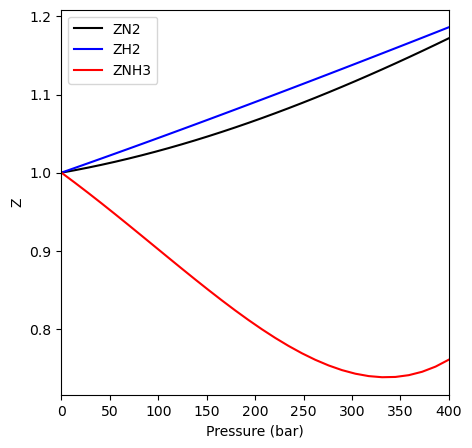

In [11]:
ZN  = lambda P: (1 + 2.1735e-4*P + 6.2923e-7*P**2 - 2.3065e-10*P**3 - 3.0835e-14*P**4)
ZH  = lambda P: (1 + 4.3484e-4*P + 9.5380e-8*P**2 - 5.4028e-11*P**3 + 1.5314e-14*P**4)
ZA  = lambda P: (1 - 9.0961e-4*P - 1.0349e-6*P**2 + 2.6566e-09*P**3 + 4.6925e-12*P**4)

# Plot compressibility factors as functions of pressure
pplot = np.linspace(0,400,30) #We'll plot from 0 bar to 400 bar...
plt.figure(figsize = (5,5))
plt.plot(pplot, ZN(pplot), color = 'black', label = 'ZN2')
plt.plot(pplot, ZH(pplot), color = 'blue', label = 'ZH2')
plt.plot(pplot, ZA(pplot), color = 'red', label = 'ZNH3')
plt.xlim(pplot[0], pplot[-1])
plt.xlabel('Pressure (bar)')
plt.ylabel('Z')
plt.legend()
plt.show()

##### Use compressibility factors to find fugacity coefficients

Now that we have expressions for compressibility factors, we'll use them to define integrands that we can use to solve for fugacity coefficients.  Again, we are trying to solve:

$$\phi_j = \exp\left(\int_0^P\frac{\left(Z_j(P)-1\right)}{P}d\!P\right)$$

The integrand is the part we are integrating:

$$\phi_j = \exp\left(\int_0^P \textrm{integrand}(P) \ d\!P\right)$$

So we will now write functions that define the integrands that we need to integrate. Once defined, we pass them to `quad()` to figure out the fugacity coefficient at a given pressure.

```{tip}
We are using a `lambda` function since this is a nice, easy one line function. We are passing Pressure as a function argument, which then gets passed into $Z(P)$. Functions are neat this way---it may not have occurred to you before, but you can totally nest a function inside of another function if it is useful to you!!
```

In [12]:
INTN  = lambda P: (ZN(P) - 1)/P
INTH  = lambda P: (ZH(P) - 1)/P
INTA  = lambda P: (ZA(P) - 1)/P

##### Integrate using gaussian quadrature to find the fugacity coefficient at specific P

Now that we have the integrands defined, we can use Gaussian Quadrature to integrate them to any pressure we want. This is just integrating the integrand as a function of pressure from 0 to P.  Here, we'll use an upper limit of 200 bar since that is what the problem specifies for industrial synthesis of ammonia, i.e., we want to know the fugacity coefficient at $P = 200 \ \mathrm{bar}$.

```{important}
Note that in calculating the fugacity coefficients this way, we can see that they are strict functions of pressure only. We know the pressure in this system is $P = 200 \ \mathrm{bar}$, so these are known, fixed quantities, and we have reduced our equilibrium problem to a single unknown, $\varepsilon$.
```

In [13]:
phiN, errN = np.exp(quad(INTN, 0, 200))
phiH, errH = np.exp(quad(INTH, 0, 200))
phiA, errA = np.exp(quad(INTA, 0, 200))
# phiA, errA = np.exp(quad(INTA, 1e-10, 200))
print(phiN, phiH, phiA)

1.0569920645443989 1.0927939252498104 0.8239390392243064


##### Adapt ammonia synthesis equilibrium problem to include fugacity coefficients

Now, we're in a position to adapt our ammonia objective function to include fugacity coefficients. Despite the added complexity, this is still a univariate problem where we have only one unknown, $\varepsilon$. This is the only unknown because fugacity coefficients are defined as a function of pressure (which is known), and mole fractions are defined as a function of extent (which is unknown). We can therefore solve this "equation" using `opt.newton()`

In [14]:
###########################################################################
# Define univariate equilibrium function with fugacity coefficients       #
###########################################################################

def EQ3(ε):
    
    #Specifications for this problem
    T   = 673 #K
    P   = 200 #bar

    #Mole Table, this captures extent of reaction
    NN  = NN0 - ε
    NH  = NH0 - 3*ε
    NA  = NA0 + 2*ε
    NT  = NN + NH + NA
    
    #Mole fractions -- note extent is built into definitions of NA, NB, NC, NT
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
    
    #Fugacity coefficients -- generally species specific and a strong function of pressure
    ϕN = 1.0569920645443758
    ϕH = 1.0927939252498104
    ϕA = 0.8239390392243812
    
    #Activity definitions -- extents embedded in yA, yB, yC; P and P0 also show up.
    aN  = yN*ϕN*P/P0
    aH  = yH*ϕH*P/P0
    aA  = yA*ϕA*P/P0
    
    #This is our ratio of thermodynamic activities at equiliribum, i.e., Kactivity = Product(a_j^nu_j)
    KACTIVITY = aA**2/aN/aH**3
    
    #And finally, our Thermodynamic equilibrium constant
    KTHERMO = K(T)
       
    return KACTIVITY - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

ans, info = opt.newton(EQ3, 0.99, full_output = True) #This solves for the equilibrium extent

print(info.flag) #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

converged
Conversion of N2 is 0.5759, yN is 0.1489, yH is 0.4467, and yA is 0.4044


### It is much more convenient to pass T and P as extra parameters...

There are a couple of things I don't like about the above approach.  It requires us to basically re-write specifications and recalculate fugacity coefficients every time we change the temperature and the pressure.  What I personally would *like* to do is embed those calculations into my objective function so that I can just pass $(T,P)$ as arguments and have the problem solve at ***any*** $(T,P)$ that I like without having to hard-code values of the equilibrium constant or fugacity coefficients. Let's start by moving ***everything that can vary as a function of temperature or pressure*** inside of the function. We'll also give that function 3 arguments:  reaction extent, temperature, and pressure, i.e., $f(\varepsilon, T, P)$

We should view this as a temporary or intermediate function that handles the majority of necessary calculations but is not quite compatbile with the default formatting requirements for algebraic equation solvers, which typically operate on a function that has a single argument comprising unknowns.

In [21]:
################################################################################################################################
# Build an intermediate function that takes extent, temperature, and pressure as arguments and returns K - KCOMP as an output. #
################################################################################################################################

def tempfun2(ε, T, P):
    
    #Mole Table, this captures extent of reaction
    NN  = NN0 - ε
    NH  = NH0 - 3*ε
    NA  = NA0 + 2*ε
    NT  = NN + NH + NA
    
    #Mole fractions -- note extent is built into definitions of NA, NB, NC, NT
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
    
    #Fugacity coefficients -- generally species specific and a strong function of pressure; reuse integrand functions
    ϕN, errN = np.exp(quad(INTN, 0, P))
    ϕH, errH = np.exp(quad(INTH, 0, P))
    ϕA, errA = np.exp(quad(INTA, 1e-10, P)) #Note - I need a lower limit not equal to zero here due to some instability at some pressures
    
    #Activity definitions -- extents embedded in yA, yB, yC; P and P0 also show up.
    aN  = yN*ϕN*P/P0
    aH  = yH*ϕH*P/P0
    aA  = yA*ϕA*P/P0
    
    #This is our ratio of thermodynamic activities at equiliribum, i.e., Kactivity = Product(a_j^nu_j)
    KACTIVITY = aA**2/aN/aH**3
    
    #Calculate the equilibrium constant at T = Trxn
    KTHERMO = K(T) 
    
    return KACTIVITY - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

### Lambda functions

Now we just have to address the fact that `opt.newton()` will, by default, accept a function that takes a single argument ($\varepsilon$ in this case)...here, we need to give 3 arguments to our function $(\varepsilon, T, P)$.  Similar to the examples covered in [Notebook 09](https://jqbond.github.io/CEN587/Notebooks/587-N09.html), we can use `lambda` functions or the more Python-specific `args` keyword.

In [22]:
##############################################################################################################################################
# Solving the equilibrium problem by passing temperature and pressure using lambda functions                                                 #
##############################################################################################################################################

Trxn = 673 #K
Prxn  = 200 #bar
objective = lambda ε: tempfun2(ε, Trxn, Prxn)
ans, info = opt.newton(objective, 0.99, full_output = True) #This solves for the equilibrium extent

print(info.flag) #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

converged
Conversion of N2 is 0.5759, yN is 0.1489, yH is 0.4467, and yA is 0.4044


### Using the args keyword

You can also pass them directly to `opt.newton()` using the `args` keyword.  This is a pretty common option for both algebraic and ODE solvers in Python.  It is honestly pretty convenient, so it is worth knowing about.

In [23]:
##############################################################################################################################################
# Solving the equilibrium problem by passing temperature and pressure directly to intermediate function using the args keyword               #
##############################################################################################################################################

Trxn = 673 #K
Prxn = 200 #bar
ans, info = opt.newton(tempfun2, 0.98, args = (Trxn, Prxn), full_output = True) #This solves for the equilibrium extent

print(info, '\n') #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

      converged: True
           flag: converged
 function_calls: 28
     iterations: 27
           root: 0.5758932567368036
         method: secant 

Conversion of N2 is 0.5759, yN is 0.1489, yH is 0.4467, and yA is 0.4044


### Could we automate this type of calculation with a loop?

This is a common situation where we might be interested in understanding the solution to our problem for large sets of Temperatures, Pressures, or (more likely) both.  We will see here that if I've built a general objective function that accepts extra parameters as arguments, this is very easy to do in a programming language.  First, we'll solve the problem for a range of Temperatures at P = 1 bar.

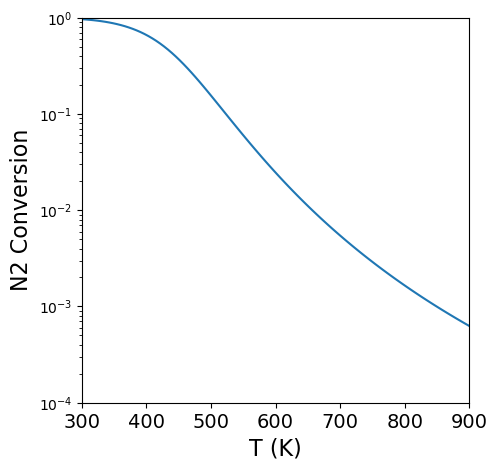

In [24]:
########################################################################################################
# Solving for equilibrium conversion at 1 bar and many temperatures with a single for loop             #
########################################################################################################

PRXN = 1   #bar
# TSET = [298, 323, 573]
TSET = np.linspace(300, 900, 100) #K

# If you know you want to store the result of each pass through the loop, you can pre-allocate storage arrays and then update them on each pass through the loop
XOUT = np.zeros(len(TSET))
flag = np.zeros(len(TSET))

for j in range(0, len(TSET), 1):
    # print(j, TSET[j])
    objective = lambda ε: tempfun2(ε, TSET[j], PRXN)
    ans, info = opt.newton(objective, 0.99, full_output = True)
    # print(ans, info.converged, '\n')
    XOUT[j] = ans/NN0
    flag[j] = info.converged

# print('\n', ans)
# print('\n', XOUT)
# print('\n', flag)

plt.figure(figsize = (5,5))
plt.plot(TSET, XOUT)
plt.yscale('log')
plt.ylabel('N2 Conversion', fontsize = 16)
plt.ylim(10**-4, 1)
plt.xlabel('T (K)', fontsize = 16)
plt.xlim(300, 900)
plt.xticks(np.arange(300, 901, 100), fontsize = 14)
plt.show()

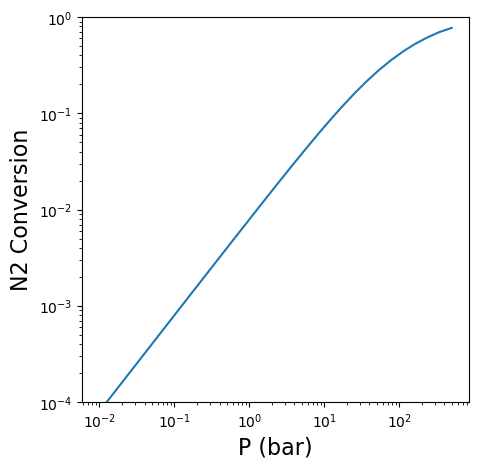

In [19]:
########################################################################################################
# Solving for equilibrium conversion at 673K and many pressures with a single for loop                 #
########################################################################################################

TRXN = 673 #K
PSET = [1, 2, 5, 10]   #bar
PSET = np.logspace(-2, np.log10(500), 30) #np.logspace(starting power of 10, ending power of 10, number of steps)

XOUT = np.zeros(len(PSET))
flag = np.zeros(len(PSET))

for j in range(0, len(PSET), 1):
    # print(j, PSET[j])
    objective = lambda ε: tempfun2(ε, TRXN, PSET[j])
    # ans, info = opt.newton(objective, 0.99, full_output = True)
    ans, info = opt.brentq(objective, 1e-6, 0.99999, xtol = 1e-8, rtol = 1e-8, full_output = True) #Brent's method is better for stability when it is hard to make good initial guesses
    # print(ans, info.converged, '\n')
    XOUT[j] = ans/NN0
    flag[j] = info.converged

# print('\n', ans)
# print('\n', XOUT)
# print('\n', flag)

plt.figure(figsize = (5,5))
plt.plot(PSET, XOUT)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N2 Conversion', fontsize = 16)
plt.ylim(10**-4, 1)
plt.xlabel('P (bar)', fontsize = 16)
# plt.xlim(0, 500)
plt.show()

### Why not do this for an absurd number of T and P values with a loop?

Perhaps it would be useful to map the equilibrium conversion in 3D space as a function of reaction temperature and reaction pressure.  We can easily do this!  One option is a for loop that will solve the objective function for a lot of temperatures and pressures.

```{note}
It may not look like much, but the small block of code below solves the algebraic equation that describes chemical equilibrium for a 30x30 set of temperature and pressure combinations. It is literally solving 900 distinct nonlinear algebraic equations -- one on each pass through the loop.
```

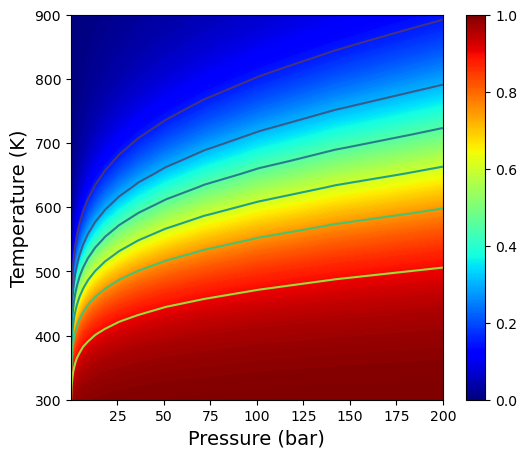

In [20]:
########################################################################################################
# Solving for equilibrium conversion at many temperatures and pressures with two nested for loops      #
########################################################################################################

TSET = np.linspace(300, 900, 30)
PSET = np.logspace(-2, np.log10(200), 30)
XOUT = np.zeros((len(TSET), len(PSET)))
flag = np.zeros((len(TSET), len(PSET)))
# print(XOUT.shape, flag.shape)

for i in range(0, len(TSET)):
    for j in range(0, len(PSET)):
        # print(i, j, TSET[i], PSET[j])
        objective = lambda ex: tempfun2(ex, TSET[i], PSET[j])
        ans, info = opt.brentq(objective, 1e-6, 0.99999, xtol = 1e-8, rtol = 1e-8, full_output = True)
        # XOUT[i,j] = ans/NN0
        # flag[i,j] = info.converged
        if info.converged == True:
            XOUT[i,j] = ans/NN0
        if info.converged == False:
            print(info)
# print(XOUT)
# print(flag)

plt.figure(figsize = (6,5))
plt.contour(PSET, TSET, XOUT)
plt.contourf(PSET, TSET, XOUT)
plt.contourf(PSET, TSET, XOUT, levels = np.linspace(0, 1.0, 201))
plt.contourf(PSET, TSET, XOUT, levels = np.linspace(0, 1.0, 201), cmap = 'jet')
plt.xlim(PSET[0], PSET[-1])
plt.xlabel('Pressure (bar)', fontsize = 14)
plt.ylim(TSET[0], TSET[-1])
plt.ylabel('Temperature (K)', fontsize = 14)
plt.colorbar(ticks = np.arange(0, 1.1, 0.2))
plt.show()